In [1]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseEstimator, fit_wrapper, transform_wrapper

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler

from statsmodels.tsa.deterministic import Fourier, DeterministicProcess

import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import Pipeline

from src.model_validation import TSCrossValidate, summary_evaluation, fold_evaluation
from src.model_helpers import DailyModel
from src.sharpe import score_sharpe

import matplotlib.pyplot as plt
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("data_raw/train.csv")
df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [3]:
class FeatureEng(BaseEstimator):
    def __init__(self, u1=True, u2=True, add_ts=True, z2=True,
                 riskadj_m4=True, quant_p11=True, fed_model=True,
                 glob_vol=True, relmom=True, mom_div=True, mompersistence=True,
                 momregime=True, vol_spread=True, price_mom=True, rate_sens=True):
        super().__init__()
        self.u1 = u1
        self.u2 = u2
        self.add_ts = add_ts
        self.z2 = z2
        self.riskadj_m4 = riskadj_m4
        self.quant_p11 = quant_p11
        self.fed_model = fed_model
        self.glob_vol = glob_vol
        self.relmom = relmom
        self.mom_div = mom_div
        self.mompersistence = mompersistence
        self.momregime = momregime
        self.vol_spread = vol_spread
        self.price_mom = price_mom
        self.rate_sens = rate_sens
    
    @fit_wrapper
    def fit(self, X, y=None):
        if self.add_ts:
            fourier = Fourier(period=22, order=4)

        self.dp = DeterministicProcess(
            constant=False,
            index=X["date_id"],
            order=0,
            seasonal=False,
            period=5,
            fourier=2,
            drop=True,
            additional_terms=[fourier],
        )

        return self

    @transform_wrapper
    def transform(self, X, y=None):
        Xtr = X.copy()
        if self.u1: # U1: Interest rate change
            Xtr["U1"] = Xtr["I2"] - Xtr["I1"]
        if self.u2: # U2: Momentum to interest rate ratio
            Xtr["U2"] = Xtr["M11"] / ((Xtr["I2"] + Xtr["I9"] + Xtr["I7"]) / 3)

        if self.add_ts:
            in_sample = self.dp.in_sample().reset_index()
            out_of_sample = self.dp.out_of_sample(steps=3000).reset_index().rename(columns={"index": "date_id"})
            ts = pd.concat([in_sample, out_of_sample], ignore_index=True)
            ts.columns = [c.replace("(", "_").replace(")", "_").replace(",", "_") for c in ts.columns]
            Xtr = pd.merge(Xtr, in_sample, on="date_id", how="left")

        if self.z2:
            if "forward_returns_lag_1" in Xtr and "mom_22d" in Xtr and "vol_22d" in Xtr:
                Xtr['zscore_22'] = (Xtr["forward_returns_lag_1"] - df['mom_22d']) / (df['vol_22d'] + 1e-8)

        # 1. Volatility-Adjusted Momentum (Signal-to-Noise)
        if self.riskadj_m4:
            if 'M4' in Xtr.columns and 'V13' in Xtr.columns:
                Xtr['Quant_RiskAdj_M4'] = Xtr['M4'] / (Xtr['V13'].abs() + 1e-6)

        # 2. Regime-Conditional Valuation (Fear Discount)
        if self.quant_p11:
            if 'P11' in Xtr.columns and 'V13' in Xtr.columns:
                Xtr['Quant_Regime_P11'] = Xtr['P11'] * Xtr['V13']

        # 3. The "Fed Model" (Rates vs Value)
        if self.fed_model:
            rate_col = 'I2' if 'I2' in Xtr.columns else 'risk_free_rate'
            if 'P11' in Xtr.columns and rate_col in Xtr.columns:
                Xtr['Quant_FedModel_P11'] = Xtr['P11'] * Xtr[rate_col]

        # 4. Composite Volatility (Global Risk Factor)
        if self.glob_vol:
            vol_cols = ['V13', 'V9', 'V7']
            available_vols = [c for c in vol_cols if c in Xtr.columns]
            if available_vols:
                Xtr['Quant_Global_Vol'] = Xtr[available_vols].mean(axis=1)

        # 5. Cross-Sectional Momentum (Relative Strength)
        if self.relmom:
            momentum_cols = [c for c in Xtr.columns if c.startswith('M')]
            if len(momentum_cols) > 1:
                mom_mean = Xtr[momentum_cols].mean(axis=1)
                if 'M4' in Xtr.columns:
                    Xtr['Quant_RelMom_M4'] = Xtr['M4'] / (mom_mean.abs() + 1e-6)
                if 'M1' in Xtr.columns:
                    Xtr['Quant_RelMom_M1'] = Xtr['M1'] / (mom_mean.abs() + 1e-6)
            
        # 6. Momentum Divergence (Sector Rotation Signal)
        if self.mom_div:
            if 'M4' in Xtr.columns and 'M1' in Xtr.columns:
                Xtr['Quant_MomDiv_Tech'] = Xtr['M4'] - Xtr['M1']  # Tech vs Broad Market
            if 'M2' in Xtr.columns and 'M3' in Xtr.columns:
                Xtr['Quant_MomDiv_Value'] = Xtr['M2'] - Xtr['M3']  # Value rotation
            
        # 7. Momentum Persistence (Trend Strength)
        if self.mompersistence:
            if 'M4' in Xtr.columns:
                Xtr['Quant_M4_Persistence'] = (Xtr['M4'] > 0).astype(int) * Xtr['M4'].abs()
            if 'M1' in Xtr.columns:
                Xtr['Quant_M1_Persistence'] = (Xtr['M1'] > 0).astype(int) * Xtr['M1'].abs()
            
        # 8. Volatility Regime Indicators
        if self.momregime:
            if 'V13' in Xtr.columns:
                # Simple regime: high vol = 1, low vol = 0
                v13_rolling = Xtr['V13'].rolling(window=20, min_periods=1).mean()
                Xtr['Quant_VolRegime_High'] = (Xtr['V13'] > v13_rolling * 1.2).astype(int)
                Xtr['Quant_VolRegime_Low'] = (Xtr['V13'] < v13_rolling * 0.8).astype(int)
            
        # 9. Cross-Asset Volatility Spread (Risk Dispersion)
        if self.vol_spread:
            vol_cols = ['V13', 'V9', 'V7']
            available_vols = [c for c in vol_cols if c in Xtr.columns]
            if len(available_vols) >= 2:
                Xtr['Quant_Vol_Spread'] = Xtr[available_vols].max(axis=1) - Xtr[available_vols].min(axis=1)
            
        # 10. Price-Momentum Alignment (Trend Confirmation)
        if self.price_mom:
            if 'P11' in Xtr.columns and 'M4' in Xtr.columns:
                Xtr['Quant_Price_Mom_Align'] = Xtr['P11'] * Xtr['M4']
            if 'P1' in Xtr.columns and 'M1' in Xtr.columns:
                Xtr['Quant_Price_Mom_Align_Broad'] = Xtr['P1'] * Xtr['M1']
            
        # 11. Rate-of-Change Features (Acceleration) - EXPANDED
            # if 'M4' in Xtr.columns:
            #     Xtr['Quant_M4_RoC'] = Xtr['M4'] - Xtr['M4'].shift(1)
            #     Xtr['Quant_M4_RoC_2'] = Xtr['M4'] - Xtr['M4'].shift(2)  # 2-period momentum
            # if 'M1' in Xtr.columns:
            #     Xtr['Quant_M1_RoC'] = Xtr['M1'] - Xtr['M1'].shift(1)
            # if 'V13' in Xtr.columns:
            #     Xtr['Quant_V13_RoC'] = Xtr['V13'] - Xtr['V13'].shift(1)
            #     Xtr['Quant_V13_RoC_2'] = Xtr['V13'] - Xtr['V13'].shift(2)  # Vol acceleration
            # if 'V9' in Xtr.columns:
            #     Xtr['Quant_V9_RoC'] = Xtr['V9'] - Xtr['V9'].shift(1)
            
        # 12. Interest Rate Sensitivity
        if self.rate_sens:
            rate_col = 'I2' if 'I2' in Xtr.columns else 'risk_free_rate'
            if rate_col in Xtr.columns:
                rate_change = Xtr[rate_col] - Xtr[rate_col].shift(1)
                if 'P11' in Xtr.columns:
                    Xtr['Quant_Rate_Sensitivity_P11'] = Xtr['P11'] * rate_change
                # Volatility response to rate changes
                if 'V13' in Xtr.columns:
                    Xtr['Quant_Vol_Rate_Response'] = Xtr['V13'] * rate_change

        return Xtr

In [4]:
fe = FeatureEng()

fe.fit(df)
tmp = fe.transform(df)

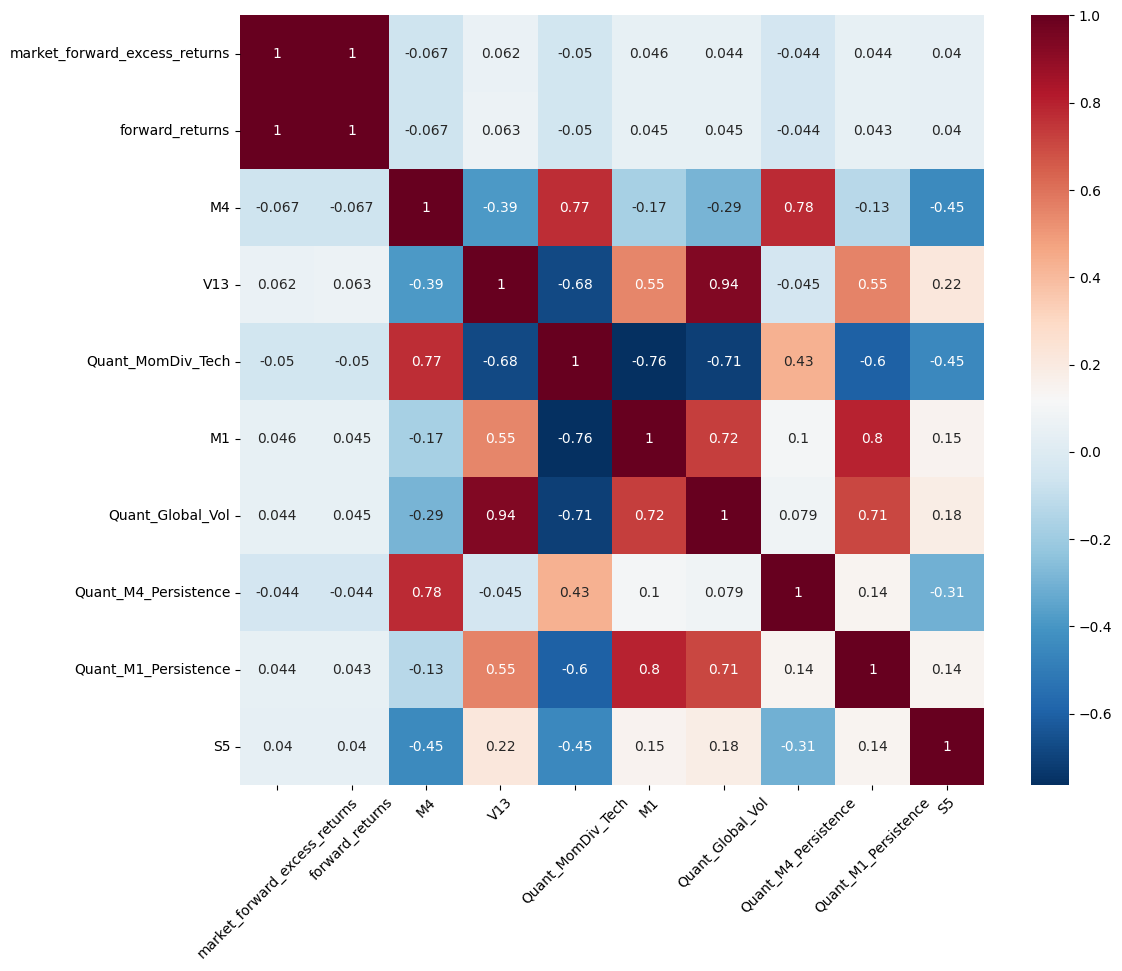

market_forward_excess_returns    1.000000
forward_returns                  0.999943
M4                              -0.066600
V13                              0.062395
Quant_MomDiv_Tech               -0.050484
M1                               0.046111
Quant_Global_Vol                 0.044198
Quant_M4_Persistence            -0.044072
Quant_M1_Persistence             0.043667
S5                               0.040010
Name: market_forward_excess_returns, dtype: float64

In [54]:
tml.plot_correlations(data=tmp, target='market_forward_excess_returns', limit=10, annot=True)

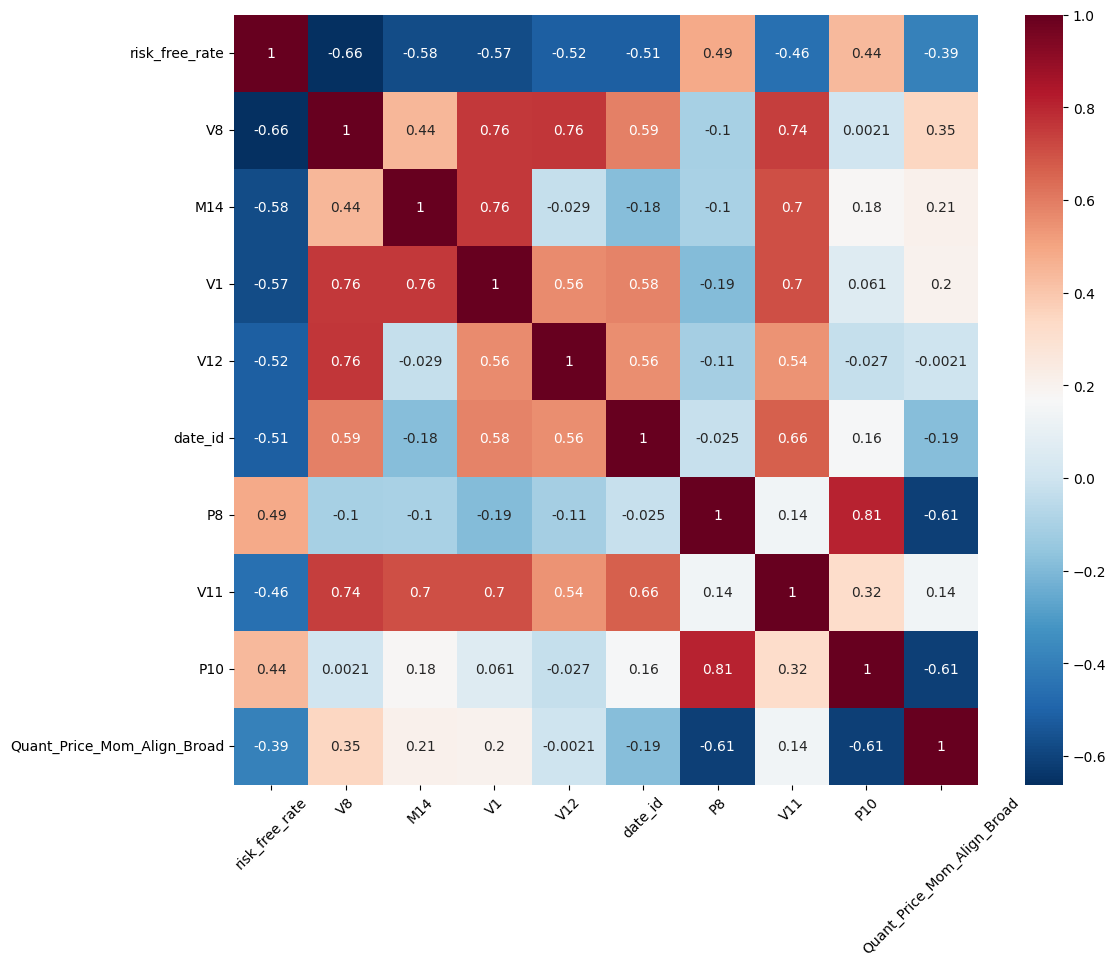

risk_free_rate                 1.000000
V8                            -0.661568
M14                           -0.575216
V1                            -0.571406
V12                           -0.517913
date_id                       -0.513432
P8                             0.486511
V11                           -0.458049
P10                            0.438244
Quant_Price_Mom_Align_Broad   -0.394144
Name: risk_free_rate, dtype: float64

In [53]:
tml.plot_correlations(data=tmp, target="risk_free_rate", limit=10, annot=True)